# 3A.mr - 2015 - PageRank avec PIG

L'algorithme [PageRank](https://en.wikipedia.org/wiki/PageRank) propose une mesure de la pertinence d'un site. Il fut inventé par les fondateurs de google. L'implémentation proposée ici s'est appuyée sur celle proposée dans [Data-Intensive Text Processing with MapReduce](http://lintool.github.io/MapReduceAlgorithms/MapReduce-book-final.pdf), page 106. L'algorithme est d'abord appliqué sur un jeu de test (plus petit et permettant un développement rapide) puis à un jeu plus consistent : [Google web graph](http://snap.stanford.edu/data/web-Google.html). Auteurs : *M. Amestoy M., A. Auffret*.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

### Connexion au cluster

In [2]:
import pyquickhelper
params={"blob_storage":"", 
        "password1":"", 
        "hadoop_server":"", 
        "password2":"", 
        "username":""}
pyquickhelper.ipythonhelper.open_html_form(params=params,title="server + hadoop + credentials", key_save="blobhp")

In [3]:
import pyensae
%load_ext pyensae
%load_ext pyenbc
blobstorage = blobhp["blob_storage"]
blobpassword = blobhp["password1"]
hadoop_server = blobhp["hadoop_server"]
hadoop_password = blobhp["password2"]   
username = blobhp["username"]
client, bs =  %hd_open
client, bs

(<pyensae.remote.azure_connection.AzureClient at 0x86b2550>,
 <azure.storage.blobservice.BlobService at 0x86b2518>)

### Création d'un petit jeu de données

On crée un set de données pour tester l'algorithme. (en reprenant celui présenté dans l'article)

In [4]:
with open("DataTEST.txt", "w") as f :
    f.write("1"+"\t"+"2"+"\n"+"1"+"\t"+"4"+"\n"+"2"+"\t"+"3"+"\n"+"2"+"\t"+"5"+"\n"+"3"+"\t"+"4"+"\n"+"4"+"\t"+"5"+"\n"+"5"+"\t"+"3"+"\n"+"5"+"\t"+"1"+"\n"+"5"+"\t"+"2")

In [5]:
import pandas
df = pandas.read_csv("DataTEST.txt", sep="\t",names=["Frm","To"])
df

,Frm,To
0,1,2
1,1,4
2,2,3
3,2,5
4,3,4
5,4,5
6,5,3
7,5,1
8,5,2


On importe ce graphe:

In [6]:
%blob_up DataTEST.txt /$PSEUDO/Data/DataTEST.txt

'$PSEUDO/Data/DataTEST.txt'

On vérifie que les données ont bien été chargées:

In [7]:
%blob_ls /$PSEUDO/Data/

,name,last_modified,content_type,content_length,blob_type
0,xavier/Data/DataTEST.txt,"Tue, 14 Jul 2015 20:41:01 GMT",application/octet-stream,43,BlockBlob


### Récupération de données réelles

On fait de même avec les données réelles : [Google web graph](http://snap.stanford.edu/data/web-Google.html)

In [8]:
pyensae.download_data("web-Google.txt.gz", url="http://snap.stanford.edu/data/")

    downloading of  http://snap.stanford.edu/data/web-Google.txt.gz  to  web-Google.txt.gz


['.\\web-Google.txt']

In [9]:
%head web-Google.txt

On filtre les premières lignes.

In [10]:
with open("web-Google.txt", "r") as f:
    with open("DataGoogle.txt", "w") as g:
        for line in f:
            if not line.startswith("#"):
                g.write(line)

In [11]:
%head DataGoogle.txt

In [12]:
%blob_up DataGoogle.txt /$PSEUDO/Data/DataGoogle.txt

'$PSEUDO/Data/DataGoogle.txt'

In [13]:
%blob_ls /$PSEUDO/Data/

,name,last_modified,content_type,content_length,blob_type
0,xavier/Data/DataGoogle.txt,"Tue, 14 Jul 2015 21:10:13 GMT",application/octet-stream,75379926,BlockBlob
1,xavier/Data/DataTEST.txt,"Tue, 14 Jul 2015 20:41:01 GMT",application/octet-stream,43,BlockBlob


### Algorithme Page Rank

**Initialisation de la table**

In [14]:
%%PIG Creation_Graph.pig

Arcs = LOAD '$CONTAINER/$PSEUDO/Data/$path' 
       USING PigStorage('\t') 
       AS (frm:int,to:int);

GrSort = GROUP Arcs BY frm;
deg_sort = FOREACH GrSort 
           GENERATE COUNT(Arcs) AS degs, Arcs , group AS ID;

GrEntr = GROUP Arcs BY to;

GrFin= JOIN deg_sort BY ID, 
            GrEntr BY group;

N = FOREACH (group GrSort ALL) 
    GENERATE COUNT(GrSort);
    
Pr = FOREACH GrFin
     GENERATE deg_sort::ID AS ID , (float) 1 / (float)N.$0 AS PageRank;
            
PageRank = JOIN GrFin BY deg_sort::ID, 
                Pr BY ID;
        
STORE PageRank 
INTO '$CONTAINER/$PSEUDO/Projet/SortTest.txt' 
USING PigStorage('\t') ;

In [15]:
client.pig_submit(bs, 
                  client.account_name, 
                  "Creation_Graph.pig", 
                  params=dict(path="DataTEST.txt"), 
                  stop_on_failure=True)

{'id': 'job_1435385350894_0001'}

In [16]:
st = %hd_job_status job_1435385350894_0001
st["id"],st["percentComplete"],st["status"]["jobComplete"]

('job_1435385350894_0001', '100% complete', True)

In [17]:
%tail_stderr job_1435385350894_0001 10

**Itérations**

On crée une macro pour répéter les iterations.

In [18]:
%%PIG iteration.pig

gr = LOAD '$CONTAINER/$PSEUDO/Projet/SortTest.txt' 
     USING PigStorage('\t') 
     AS (DegS:long,Asort:{(frm: int,to: int)},Noeud:int,Noeud2:int,Aent:{(frm: int,to: int)},ID: int,PageRank: float);

Arcs = LOAD '$CONTAINER/$PSEUDO/Data/DataTEST.txt' 
       USING PigStorage('\t') 
       AS (frm:int,to:int);

Graph = FOREACH gr
        GENERATE Noeud , DegS, PageRank AS Pinit, PageRank,  PageRank/ (float) DegS AS Ratio;


DEFINE my_macro(G,A,ALP) RETURNS S {
    
    Gi= FOREACH $G GENERATE Noeud , Ratio;
    GrEntr = JOIN $A BY frm , Gi BY Noeud ;
    Te = GROUP GrEntr BY to;
    so = FOREACH Te GENERATE SUM(GrEntr.Ratio) AS Pr, group AS ID;
    tu = JOIN $G BY Noeud, so BY ID;
    sort = FOREACH tu GENERATE Noeud , DegS, Pinit, $ALP*Pinit+(1-$ALP)*Pr AS PageRank;
    $S = FOREACH sort GENERATE Noeud , DegS, Pinit, PageRank, PageRank/ (float) DegS AS Ratio;
}

Ite1 = my_macro(Graph,Arcs,$alpha);
Ite2 = my_macro(Ite1,Arcs,$alpha);
Ite3 = my_macro(Ite2,Arcs,$alpha);
Ite4 = my_macro(Ite3,Arcs,$alpha);
Ite5 = my_macro(Ite4,Arcs,$alpha);
Ite6 = my_macro(Ite5,Arcs,$alpha);
Ite7 = my_macro(Ite6,Arcs,$alpha);
Ite8 = my_macro(Ite7,Arcs,$alpha);

Dump Ite1;
dump Ite8;

In [19]:
jid = client.pig_submit(bs, 
                  client.account_name, 
                  "iteration.pig", 
                  params=dict(alpha="0"), 
                  stop_on_failure=True )
jid

{'id': 'job_1435385350894_0006'}

In [20]:
st = %hd_job_status job_1435385350894_0006
st["id"],st["percentComplete"],st["status"]["jobComplete"]

('job_1435385350894_0006', '100% complete', True)

In [21]:
%tail_stderr job_1435385350894_0006 20

On peut alors s'intéresser aux vraies données !

### Avec les données Google

**initialisation**

In [22]:
%%PIG Creation_Graph2.pig

Arcs = LOAD '$CONTAINER/$PSEUDO/Data/$path' 
       USING PigStorage('\t') 
       AS (frm:int,to:int);

GrSort = GROUP Arcs BY frm;
deg_sort = FOREACH GrSort 
           GENERATE COUNT(Arcs) AS degs, Arcs , group AS ID;

GrEntr = GROUP Arcs BY to;
GrFin = JOIN deg_sort BY ID, 
        GrEntr BY group;

N = FOREACH (GROUP GrSort ALL) 
    GENERATE COUNT(GrSort);
Pr = FOREACH GrFin 
     GENERATE deg_sort::ID AS ID , (float) 1 / (float)N.$0 AS PageRank;
PageRank = JOIN GrFin BY deg_sort::ID, Pr BY ID;
        
STORE PageRank 
INTO '$CONTAINER/$PSEUDO/Projet/SortGoogle.txt' 
USING PigStorage('\t') ;

In [23]:
client.pig_submit(bs, client.account_name, "Creation_Graph2.pig", params=dict(path="DataGoogle.txt"), stop_on_failure=True )

{'id': 'job_1435385350894_0037'}

In [24]:
st = %hd_job_status job_1435385350894_0037
st["id"],st["percentComplete"],st["status"]["jobComplete"]

('job_1435385350894_0037', '100% complete', True)

In [25]:
%tail_stderr job_1435385350894_0037 20

In [26]:
%%PIG iteration2.pig

gr = LOAD '$CONTAINER/$PSEUDO/Projet/SortGoogle.txt' 
    USING PigStorage('\t') 
    AS (DegS:long,Asort:{(frm: int,to: int)},Noeud:int,Noeud2:int,Aent:{(frm: int,to: int)},ID: int,PageRank: float);

Arcs = LOAD '$CONTAINER/$PSEUDO/Data/DataGoogle.txt' 
       USING PigStorage('\t') 
       AS (frm:int,to:int);

Graph = FOREACH gr 
        GENERATE Noeud , DegS, PageRank AS Pinit, PageRank,  PageRank/ (float) DegS AS Ratio;

DEFINE my_macro(G,A,ALP) RETURNS S {
    Gi= FOREACH $G GENERATE Noeud , Ratio;
    GrEntr = JOIN $A by frm , Gi by Noeud ;
    Te = GROUP GrEntr by to;
    so = FOREACH Te generate SUM(GrEntr.Ratio) AS Pr, group AS ID;
    tu = JOIN $G by Noeud, so by ID;
    sort = FOREACH tu GENERATE Noeud , DegS, Pinit, $ALP*Pinit+(1-$ALP)*Pr AS PageRank;
    $S = FOREACH sort GENERATE Noeud , DegS, Pinit, PageRank, PageRank/ (float) DegS AS Ratio;
}

Ite1 = my_macro(Graph,Arcs,$alpha);
Ite2 = my_macro(Ite1,Arcs,$alpha);
Ite3 = my_macro(Ite2,Arcs,$alpha);
Ite4 = my_macro(Ite3,Arcs,$alpha);
Ite5 = my_macro(Ite4,Arcs,$alpha);
Ite6 = my_macro(Ite5,Arcs,$alpha);
Ite7 = my_macro(Ite6,Arcs,$alpha);
Ite8 = my_macro(Ite7,Arcs,$alpha);

Dump Ite1;
dump Ite8;

STORE Ite8 INTO '$CONTAINER/$PSEUDO/Projet/PageRank.txt' USING PigStorage('\t') ;

In [27]:
client.pig_submit(bs, 
                  client.account_name, 
                  "iteration2.pig", 
                  params=dict(alpha="0.5"), 
                  stop_on_failure=True )

{'id': 'job_1435385350894_0042'}

In [28]:
st = %hd_job_status job_1435385350894_0042
st["id"],st["percentComplete"],st["status"]["jobComplete"]

('job_1435385350894_0042', '100% complete', True)

In [29]:
%tail_stderr job_1435385350894_0042 20

In [30]:
%blob_downmerge /$PSEUDO/Projet/PageRank.txt PageRank.txt

'PageRank.txt'

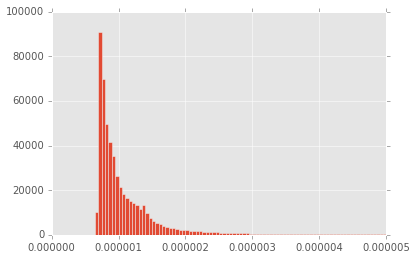

In [31]:
import pandas
import matplotlib as plt

df = pandas.read_csv("PageRank.txt", sep="\t",names=["Node","OutDeg","Pinit", "PageRank", "k"])
df
df['PageRank'].hist(bins=100, range=(0,0.000005))

In [32]:
df.sort_values("PageRank",ascending=False).head()

,Node,OutDeg,Pinit,PageRank,k
438534,751384,68,0.000001,0.000397,0.000006
351091,605856,22,0.000001,0.000381,0.000017
290922,504140,19,0.000001,0.000378,0.000020
310377,537039,27,0.000001,0.000373,0.000014
346122,597621,22,0.000001,0.000371,0.000017


In [34]:
%blob_close

True